# 量子近似优化算法

[![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.7/docs/mindquantum/docs/source_zh_cn/quantum_approximate_optimization_algorithm.ipynb)

## 概述

量子近似优化算法（Quantum Approximate Optimization Algorithm，QAOA）是利用量子计算机来近似解决组合优化问题的量子算法，最早由Farhi等人于2014年提出。在本文档里，我们将利用QAOA算法来解决最大割问题（Max-Cut），来熟悉MindQuantum中量子线路的搭建和训练。

> 本文档适用于CPU环境。
> 你可以在这里找到完整的可运行的样例代码：<https://gitee.com/mindspore/mindquantum/blob/r0.6/tutorials/source/quantum_approximate_optimization_algorithm.py>。

## 环境准备

本文档所需要的额外库：

- networkx

> `networkx`是创建、操作和研究复杂网络的结构、动态和功能库。可通过如下代码来进行安装。

```bash
pip3 install networkx
```

## Max-Cut问题描述

Max-Cut问题是图论中的一个NP-complete问题，它需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图（a），一个图由五个顶点构成，相互连接的边为```(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (0, 4)```。为了使得被切割的边最多，我们尝试通过（b）图的分割，将1、2、4分为一组，0、3分成另一组，因此可得到被切割的边有5条。后面我们将用穷举法验证这个解是否正确。当图中顶点较少时，我们可以在较短时间内通过穷举法找到最大的切割边数，但当图中顶点增多时，我们很难找到有效的经典算法来解决Max-Cut问题，因为这类NP-complete问题很有可能不存在多项式时间算法。但尽管精确解不容易得到，我们却可以想办法在多项式时间内找到问题的一个近似解，这就是近似优化算法。下面，我们介绍怎么将Max-Cut问题转化为一个哈密顿量的基态能量求解问题。

![max cut](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/docs/mindquantum/docs/source_zh_cn/images/Max_Cut.png)

## Max-Cut问题量子化

这里我们将图中的每个顶点赋予一个量子比特，当顶点被分到左边时，我们将该顶点上的量子比特设置为$\left|0\right>$态，同理，右边为$\left|1\right>$态，当两个顶点被分到不同的集合中时，这两个顶点上的比特将处于不同的量子态。例如对于第0个顶点和第1个顶点，当其连线被切割时，两个顶点上的比特对应的量子态可以表示为$|01\rangle$（顶点1：左，顶点0：右）或$|10\rangle$（顶点1：右，顶点0：左）；若它们被分到同一边，则对应量子态为$|00\rangle$或$|11\rangle$。因此我们只要找到一个哈密顿量$H$使得：当有连线的两个顶点处于不同量子态时，哈密顿量的期望值为-1，即

$$
\langle 01|H|01\rangle=-1,\quad \langle 10|H|10\rangle=-1
$$

而当有连线的顶点处于相同量子态时，哈密顿量的期望值为0，即

$$
\langle 00|H|00\rangle=0,\quad \langle 11|H|11\rangle=0
$$

随后只要使哈密顿量的期望值最小化，就可以找到最大切割边数，以及此时对应的分组情况。之所以将不同量子态时的期望值设为-1，是因为在量子神经网络的训练中，Ansatz中的参数的梯度会一直下降，同时测量值也会一直减少，该训练方法就是以找到最小值为目标，这里我们用它来寻找哈密顿量的基态能量。此时，我们选择哈密顿量$H=(Z_1Z_0-1)/2$，这里$Z$为泡利$Z$算符。此时有：

$$
Z_1Z_0|00\rangle=|00\rangle,\quad Z_1Z_0|11\rangle=|11\rangle, \quad Z_1Z_0|01\rangle=-|01\rangle, \quad Z_1Z_0|10\rangle=-|10\rangle
$$

因此当顶点被分到不同集合时：

$$
\left<01\right|H\left|01\right>=\frac{1}{2}\left<01\right|Z_1Z_0\left|01\right>-\frac{1}{2}=-1
$$

$$
\left<10\right|H\left|10\right>=\frac{1}{2}\left<10\right|Z_1Z_0\left|10\right>-\frac{1}{2}=-1
$$

而当顶点被分到同一集合中时，不难验证此时：

$$
\left<00\right|H\left|00\right>=\frac{1}{2}\left<00\right|Z_1Z_0\left|00\right>-\frac{1}{2}=0
$$

$$
\left<11\right|H\left|11\right>=\frac{1}{2}\left<11\right|Z_1Z_0\left|11\right>-\frac{1}{2}=0
$$

因此，我们只要对图中的每条边写出上述哈密顿量，然后将所有边求和，即可写出图对应的哈密顿量$H$，利用量子计算机求得$H$的基态能量与基态，我们就可以得到该图的Max-Cut切割方案与最大切割边数。我们记所有边的集合为$C$，所有边条数为$c$，则哈密顿量可写为：

$$
H=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

## 导入相关依赖

In [1]:
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

## 搭建所需求解的图

通过`add_path`可在图中添加边。最后画出图的结构。

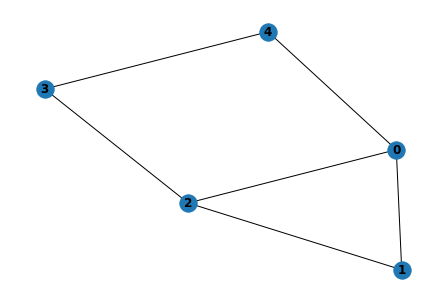

In [2]:
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [1, 2])
nx.add_path(g, [2, 3])
nx.add_path(g, [3, 4])
nx.add_path(g, [0, 4])
nx.add_path(g, [0, 2])
nx.draw(g, with_labels=True, font_weight='bold')

如上图，我们得到一个由5个节点和6条边构成的图结构。

接下来我们用穷举法来看看所有情况的切割边数。

In [3]:
for i in g.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(g, [i]))            # 一组1个节点、另一组4个节点的所有情况
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(g, [i, j]))  # 一组2个节点、另一组3个节点的所有情况

one size: [0] cut= 3
one size: [1] cut= 2
one size: [1, 0] cut= 3
one size: [2] cut= 3
one size: [2, 0] cut= 4
one size: [2, 1] cut= 3
one size: [3] cut= 2
one size: [3, 0] cut= 5
one size: [3, 1] cut= 4
one size: [3, 2] cut= 3
one size: [4] cut= 2
one size: [4, 0] cut= 3
one size: [4, 1] cut= 4
one size: [4, 2] cut= 5
one size: [4, 3] cut= 2


从以上结果可以看出，穷举法得到的最大切割边数为5，如果对节点分组的左右进行区分，则一共有4种分组方法可以使切割边数最大，即该问题有4个简并解。

## QAOA算法整体流程

1. 搭建QAOA量子线路，其中ansatz线路包含可以训练的参数
2. 初始化线路中的参数
3. 运行该量子线路，得到量子态$|\psi\rangle$
4. 计算目标哈密顿量$H_C$的期望值$\langle\psi|H_C|\psi\rangle$
5. 根据第4步的结果，使用Adam优化器优化线路中参数
6. 重复3-5步，直到第4步结果基本不再变化
7. 根据第4步的结果，算出目标问题的近似解

在该流程中，第2-6步都可以由MindSpore和MindQuantum中现成的包和函数来实现，因此我们将重点关注第1步——量子线路的搭建。

![Flowchart](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/docs/mindquantum/docs/source_zh_cn/images/QAOA_Flowchart.png)

## 搭建QAOA量子线路

先前提到，我们需要将问题对应的哈密顿量

$$
H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

最小化来找到问题的解，也就是说我们要找到该哈密顿量的基态。对此我们可以采用量子绝热演化的方法，使系统先处于某一简单哈密顿量$H_B$的基态上，然后使简单的哈密顿量$H_B$绝热地、缓慢地演化至某一复杂的哈密顿量$H_C$，根据绝热定理，系统将始终保持在哈密顿量的基态上，最终达到复杂哈密顿量$H_C$的基态。

我们将要搭建的量子线路就是采用以上思路，选取初始简单哈密顿量为

$$
H_B=\sum_i X_i
$$

并将量子线路制备到$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$，这里通过对所有量子比特作用`Hadamard`门即可实现。然后连接ansatz含参线路，通过不断地优化其中参数可以使得ansatz线路越来越接近真实绝热演化的效果，最终得到的量子线路可以视为模拟近似了一个真实的绝热演化过程。

### ansatz线路

在量子绝热演化中，首先选取初始哈密顿量

$$
H_B=\sum_i X_i
$$

并使系统处于$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$。然后缓慢地作用如下含时哈密顿量

$$
H(t)=(1-\frac{t}{T})H_B+(\frac{t}{T})H_C
$$

注意到当$t=T$时，$H(T)=H_C$。当选取的$T$足够大时（满足绝热条件），系统将始终处于$H(t)$的瞬时基态上，此时系统的量子态将从初始哈密顿量$H_B$的基态$|\psi (0)\rangle$绝热地演化到目标哈密顿量$H_C$的基态$|\psi (T)\rangle$上，即

$$
|\psi (T)\rangle=\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}|\psi(0)\rangle
$$

也就是说，ansatz线路需要模拟的就是$\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}$这一演化过程。接下来我们将对这个式子进行一些近似和化简，使其变为可以在量子线路中实现的形式。

考虑如下trotter公式

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}=\lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH(t_l)\Delta t},\quad \Delta t=\frac{T}{N},\quad t_l=l\Delta t
$$

略去$O(\Delta t^2)$项，得到

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}\approx \lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH_B(1-t_l/T)\Delta t}e^{-iH_C t_l\Delta t/T}
$$

令$\beta_l=(1-t_l/T)\Delta t$，$\gamma_l=t_l\Delta t/T$，并取$N$为一个有限大的整数，即得到QAOA的ansatz

$$
|\psi(\gamma,\beta)\rangle=\prod^p_{l=1}e^{-i\beta_l H_B}e^{-i\gamma_l H_C}|\psi_{in}\rangle
$$

因此我们需要搭建的ansatz线路由$U_C(\gamma)$和$U_B(\beta)$这两个酉变换交替构成，其中$U_C(\gamma)=e^{-i\gamma \sum_{\langle i,j\rangle}Z_i Z_j}$可以由`ZZ`门实现，$U_B(\beta)=e^{-i\beta \sum_i X_i}$则相当于在每个量子比特上作用一个`RX`旋转门，$\gamma$和$\beta$是可训练的参数。

搭建$U_C(\gamma)$对应的量子线路：

In [4]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

线路展示：

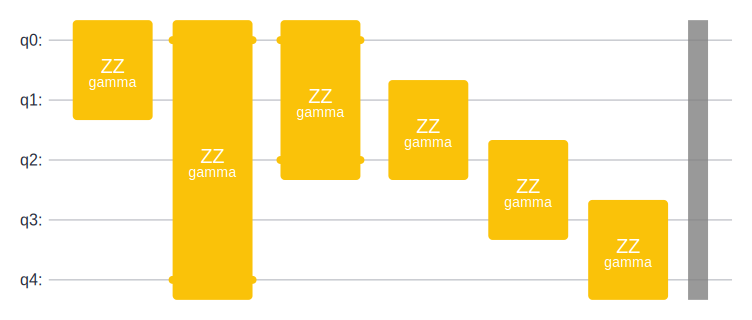

In [5]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma')
circuit.svg()

搭建$U_B(\beta)$对应的量子线路：

In [6]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

线路展示：

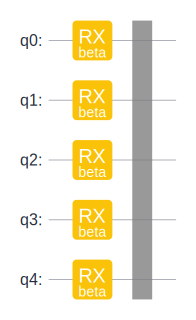

In [7]:
# pylint: disable=W0104
circuit = build_hb(g, 'beta')
circuit.svg()

实现了一层酉变换$U_B(\beta) U_C(\gamma)$的ansatz线路如下所示：

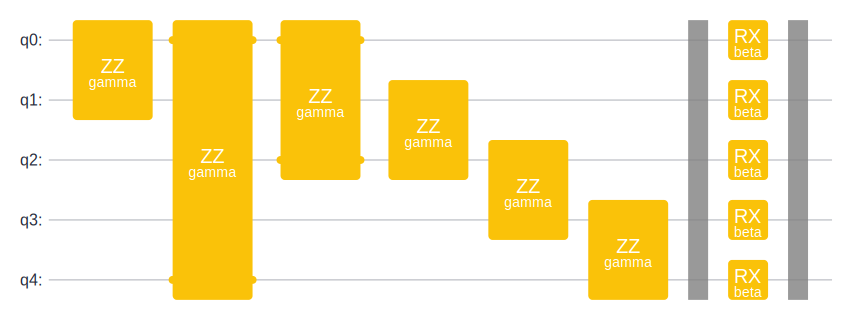

In [8]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：

In [9]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

构建图对应的哈密顿量$H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$（忽略常数项和系数）：

In [10]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

### 生成完整的量子线路和图所对应的哈密顿量

这里我们选择`p = 4`，表示选用4层的QAOA量子线路，`ansatz`是求解该问题的量子线路，`init_state_circ`是将量子态制备到均匀叠加态（$H_B$的基态）上的量子线路。

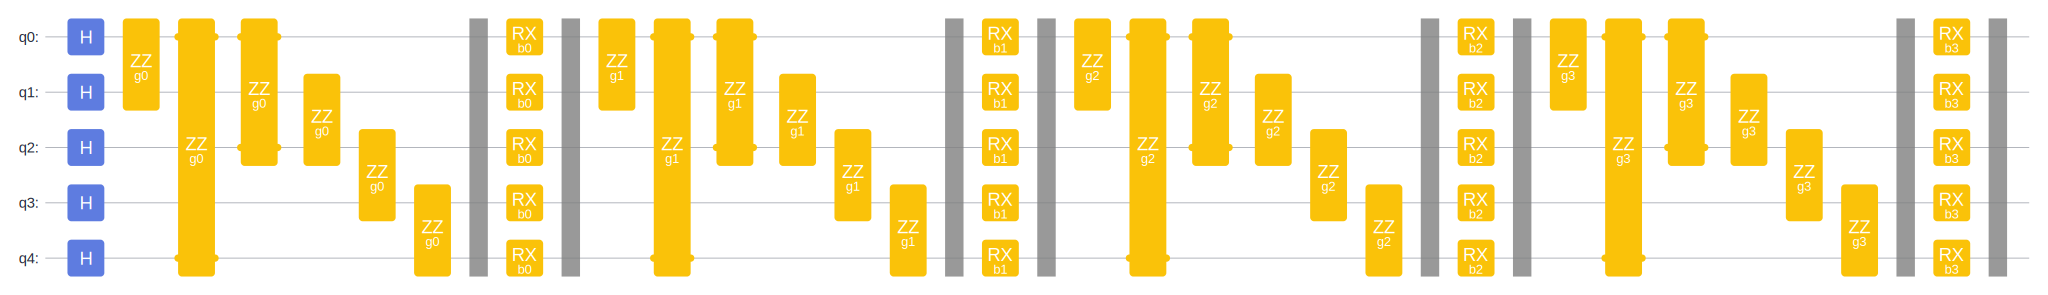

In [11]:
# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
circ.svg()

### 搭建待训练量子神经网络

由于该问题不需要编码层量子线路，我们这里使用`MQAnsatzOnlyLayer`作为待训练的量子神经网络，并采用`Adam`优化器。

In [12]:
import mindspore as ms
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

## 训练并展示结果

In [13]:
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数

train step: 0 , cut: [3.0001478]
train step: 10 , cut: [4.1718774]
train step: 20 , cut: [4.6871986]
train step: 30 , cut: [4.7258005]
train step: 40 , cut: [4.804503]
train step: 50 , cut: [4.8477592]
train step: 60 , cut: [4.8705964]
train step: 70 , cut: [4.9060946]
train step: 80 , cut: [4.933446]
train step: 90 , cut: [4.9356637]
train step: 100 , cut: [4.938308]
train step: 110 , cut: [4.9390197]
train step: 120 , cut: [4.939068]
train step: 130 , cut: [4.9392157]
train step: 140 , cut: [4.939249]
train step: 150 , cut: [4.939247]
train step: 160 , cut: [4.939255]
train step: 170 , cut: [4.939257]
train step: 180 , cut: [4.939257]
train step: 190 , cut: [4.939257]


根据上面的训练结果我们发现，该问题哈密顿量的基态能量对应的边切割数趋近于5。

### 最优参数

前面我们通过训练得到了量子线路中参数的最优值，下面，我们将最优参数提取出来并存储为字典类型，与之前线路中命名的参数一一对应。

In [14]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)

{'g0': 0.22448167, 'b0': -1.1390871, 'g1': 0.45314747, 'b1': -0.94472605, 'g2': 0.5338268, 'b2': -0.67756957, 'g3': 0.58400834, 'b3': -0.38243017}


### 概率图

我们将最优参数代入量子线路，通过对量子线路进行1000次采样，画出最终量子态在计算基矢下的概率分布：

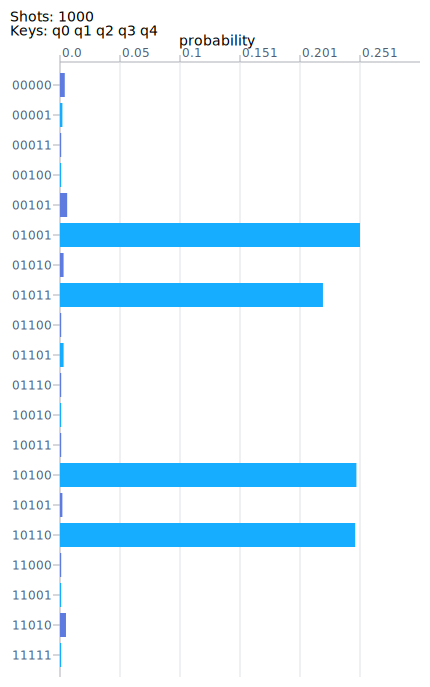

In [15]:
# pylint: disable=W0104
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果

根据概率分布图我们发现，该Max-Cut问题具有四个简并解，每个解对应的概率大概为25%。

- `01001`：编号为1、2、4的顶点在左边，编号为0、3的顶点在右边。
- `10110`：编号为0、3的顶点在左边，编号为1、2、4的顶点在右边。
- `01011`：编号为2、4的顶点在左边，编号为0、1、3的顶点在右边。
- `10100`：编号为0、1、3的顶点在左边，编号为2、4的顶点在右边。

可以发现，以上结果与先前通过穷举法得到的结果相符。

## 总结

这里我们通过量子近似优化算法来解决了Max-Cut问题，并得到了案例中的图对应的最大切割方案。

## 参考文献

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)